# Project 2

In this project, you will implement the exploratory analysis plan developed in Project 1. This will lay the groundwork for our our first modeling exercise in Project 3.

### Step 1: Load the python libraries you will need for this project 

In [45]:
#imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
from scipy.stats import kurtosis, skew, kstest, shapiro
from sklearn.neighbors import KNeighborsClassifier

plt.style.use('fivethirtyeight')

%matplotlib inline

### Step 2: Read in your data set 

In [2]:
#Read in data from source 
df_raw = pd.read_csv("../assets/admissions.csv")
df_raw.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


## Questions
#### Question 1. How many observations are in our dataset? 


In [3]:
print df_raw.shape
df_raw.count()

(400, 4)


admit       400
gre         398
gpa         398
prestige    399
dtype: int64

Answer: 400 observations of 4 variables

#### Question 2. Create a summary table

In [4]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
admit,400.0,0.317500,0.466087,0.00,0.00,0.000,1.00,1.0
gre,398.0,588.040201,115.628513,220.00,520.00,580.000,660.00,800.0
gpa,398.0,3.390930,0.380630,2.26,3.13,3.395,3.67,4.0
prestige,399.0,2.486216,0.945333,1.00,2.00,2.000,3.00,4.0


#### Question 3. Why would GRE have a larger STD than GPA?

In [5]:
print "GRE range:", df_raw['gre'].min(), " - ", df_raw['gre'].max()
print "GPA range:", df_raw['gpa'].min(), " - ", df_raw['gpa'].max()

GRE range: 220.0  -  800.0
GPA range: 2.26  -  4.0


Answer: GRE has a much larger range (0 - 800 possible, with observed values from 220 to 800) than GPA (0 - 4.0 possible, with observed values from 2.26 to 4.0). Even if these two variables' distributions have the same shape, the standard deviation of GRE will be much larger because the range of its values is much larger (580 vs. 1.74).

#### Question 4. Drop data points with missing data


In [6]:
df_nona = df_raw.dropna(axis = 0, how = 'any')

#### Question 5. Confirm that you dropped the correct data. How can you tell? 

Answer: Two ways, check the shape of our df and check again if there are any null values in our data

In [7]:
df_nona.shape

(397, 4)

In [8]:
df_nona.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

We dropped only 3 observations by removing null values and now have 397 complete observations in our dataset

#### Question 6. Create box plots for GRE and GPA

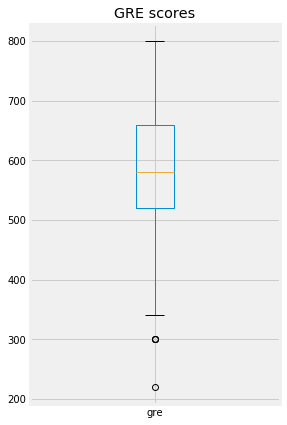

In [9]:
df_nona['gre'].plot(kind = 'box', figsize = (4, 7), title = "GRE scores")

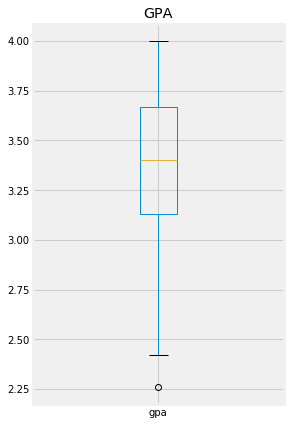

In [10]:
df_nona['gpa'].plot(kind = 'box', figsize = (4, 7), title = "GPA")

#### Question 7. What do this plots show?

Answer: Mostly they illustrate some of the descriptive stats that were output in the table on Question 2. They show the mean, interquartile range, max, and min values of these two variables. Additionally, they show the presence of a few outliers at the low end for each of these variables. 

#### Question 8. Describe each distribution 

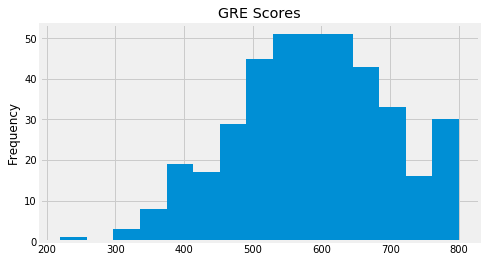

In [11]:
# plot the distribution of each variable 
df_nona['gre'].plot(kind = 'hist', bins = 15, figsize = (7, 4), title = "GRE Scores")

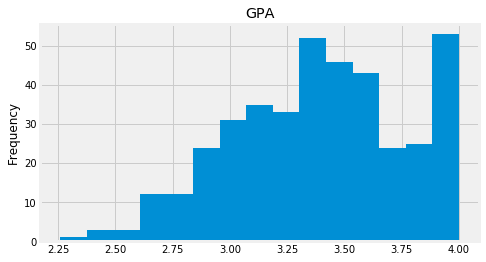

In [12]:
df_nona['gpa'].plot(kind = 'hist', bins = 15, figsize = (7, 4), title = "GPA")

#### Question 9.  If our model had an assumption of a normal distribution would we meet that requirement? 

Answer: These both look fairly normal, but both have 2 things that should give us pause:
 - There are a lot of perfect scores on the GRE (800) and perfect GPA's (4.0), throwing off the overall shape of the distributions
 - Both skew slightly left

Let's dig a little deeper.

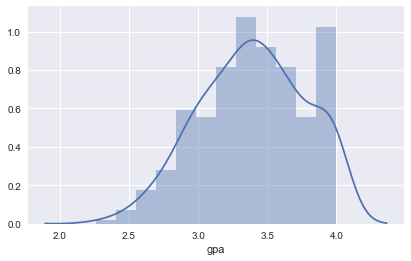

In [13]:
# To get a nice overlay of the shape of our distros, we'll use seaborn's distplot()

# Note: importing seaborn here rather than at the beginning of analysis b/c that somehow conflicted w/
# matplotlib and caused outliers to disappear in the boxplots

import seaborn as sns
sns.set(color_codes=True)

sns.distplot(df_nona['gpa'])

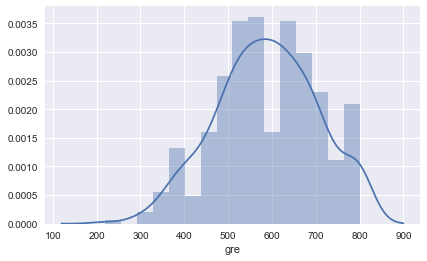

In [14]:
sns.distplot(df_nona['gre'])

If I had to describe these distributions I would say they are kind of "lumpy", yet "normal-ish".

We can look at a few stats to get more insight on whether these data should be transformed.

In [15]:
print 'GRE skew:', round(skew(df_nona['gre']), 3)
print 'GPA skew:', round(skew(df_nona['gpa']), 3)
print "------------------------------"
print 'GRE kurtosis:', round(kurtosis(df_nona['gre']), 3)
print 'GPA kurtosis:', round(kurtosis(df_nona['gpa']), 3)

GRE skew: -0.145
GPA skew: -0.216
------------------------------
GRE kurtosis: -0.344
GPA kurtosis: -0.572


The skew statistic informs us whether or not our data is symmetric (a skew of 0 indicates a distribution is symmetric). Our data for both GRE and GPA do indeed skew left, the negative skew value telling us that their values cluster towards the higher end and have longer tails toward the lower (left) end.

Kurtosis is essentially a measure of the "peakedness" of our data, and these negative values for kurtosis tell us these variables' distributions are somewhat flatter than a perfectly normal distribution.

Further, we can test if these two variables are normally distributed using two common goodness-of-fit measures, the Kolgorov-Smirnov test and the Shapiro-Wilk test. Each of these tests essentially quantifies how closely our distribution resembles a normal distribution that shares the mean and standard deviation of that variable.

In [16]:
print 'Kolgorov-Smirnov test'
print '-----------------------'
print 'GRE:', kstest(df_nona['gre'], 'norm')
print 'GPA:', kstest(df_nona['gpa'], 'norm')

Kolgorov-Smirnov test
-----------------------
GRE: KstestResult(statistic=1.0, pvalue=0.0)
GPA: KstestResult(statistic=0.98972085476178895, pvalue=0.0)


In [17]:
print 'Shapiro-Wilk test'
print '-----------------------'
print "GRE: W =", round(shapiro(df_nona['gre'])[0], 3), "  p-value =", round(shapiro(df_nona['gre'])[1], 3)
print "GPA: W =", round(shapiro(df_nona['gpa'])[0], 3), "  p-value =", round(shapiro(df_nona['gpa'])[1], 3)

Shapiro-Wilk test
-----------------------
GRE: W = 0.986   p-value = 0.001
GPA: W = 0.977   p-value = 0.0


What is most important to take away from these tests is that they propose a null hypothesis that the data are normally distributed. A p-value of nearly zero suggests we should reject that hypothesis. Neither GRE nor GPA are normally distributed according to these measures. 

#### Question 10.  Does this distribution need correction? If so, why? How? 

Answer: 
- We should probably perform some sort of transformation on these variables (though the fact they are not normally distributed does not necessarily mean it will harm our model's performance). 
- All indicators in the last question suggest these 2 variables are not in fact normally distributed.
- Our best bet would most likely be a log transformation (we will take a look at this in the bonus questions).

#### Question 11. Which of our variables are potentially colinear? 

In [18]:
# create a correlation matrix for the data
df_nona.corr()

,admit,gre,gpa,prestige
admit,1.000000,0.181202,0.174116,-0.243563
gre,0.181202,1.000000,0.382408,-0.124533
gpa,0.174116,0.382408,1.000000,-0.060976
prestige,-0.243563,-0.124533,-0.060976,1.000000


#### Question 12. What did you find?

Answer: Gre and gpa are correlated, though this correlation is not particularly strong (r = .38), so we likely won't face problems with collinearity

#### Question 13. Write an analysis plan for exploring the association between grad school admissions rates and prestige of  undergraduate schools.

Answer:
 - Code prestige as a dummy variable using get_dummies() (note: ensure we avoid the "dummy variable trap": data should have only 3 binary columns for prestige '2', '3', and '4' ranked schools)
 - Fit a logistic regression model with admit as the outcome variable that includes the prestige rank dummies as predictors
 - Interpret coefficients for the 3 dummy variables to see how prestige rank affects the probability of admittance
 - Using either new data or cross-validation within our dataset, assess model fit

#### Question 14. What is your hypothesis? 

Answer: As prestige rank decreases, the probability of admittance will also decrease (in the case of our data prestige '1' is the highest rank; we will be looking at each of the other ranks' coefficients against the probability of a prestige 1 admit).

## Bonus/Advanced

#### 1. Bonus: Explore alternatives to dropping obervations with missing data

Some common methods for imputing missing values we could implement:
 - replace null values with that variable's mean
 - replace with a subgroub mean (e.g. replace a null gpa value with the mean gpa value for observations that share the same prestige rank)
 - replace with a regression estimate (e.g. say we want to impute missing values for gre, we should regress gre on the other variables in our dataset, and then predict our missing values using that regression model)

#### 2. Bonus: Log transform the skewed data

In [33]:
df_log = pd.read_csv('../assets/admissions.csv')
df_log = df_log.dropna(axis = 0, how = 'any')

df_log['log_gre'] = np.log(df_log['gre'])
df_log['log_gpa'] = np.log(df_log['gpa'])

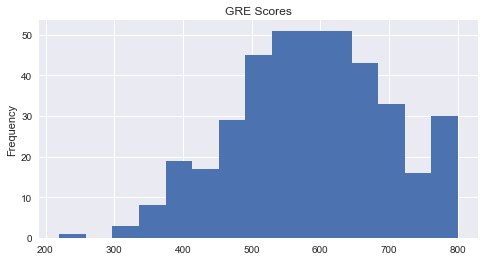

In [35]:
df_log['gre'].plot(kind = 'hist', bins = 15, figsize = (7, 4), title = "GRE Scores")

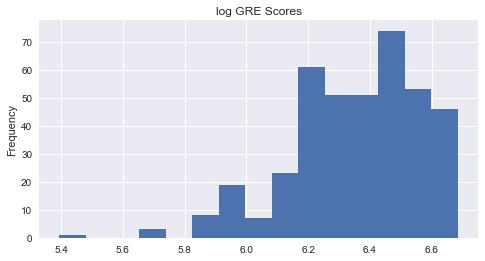

In [37]:
df_log['log_gre'].plot(kind = 'hist', bins = 15, figsize = (7, 4), title = "log GRE Scores")

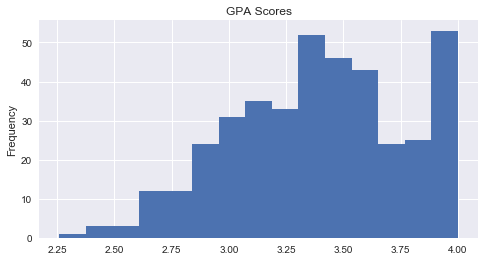

In [38]:
df_log['gpa'].plot(kind = 'hist', bins = 15, figsize = (7, 4), title = "GPA Scores")

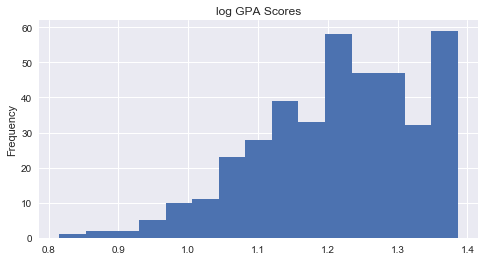

In [39]:
df_log['log_gpa'].plot(kind = 'hist', bins = 15, figsize = (7, 4), title = "log GPA Scores")

If you squint just right, you can see how the log transformations make these variables closer to normal distributions 

#### 3. Advanced: Impute missing data

In [75]:
# Replace GRE and GPA w/ mean values:
df_mean_rp = pd.read_csv('../assets/admissions.csv')

df_mean_rp.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [76]:
df_mean_rp['gre'].fillna(df_mean_rp['gre'].mean(), inplace = True)
df_mean_rp['gpa'].fillna(df_mean_rp['gpa'].mean(), inplace = True)

df_mean_rp.isnull().sum()

admit       0
gre         0
gpa         0
prestige    1
dtype: int64

So, we have successfully imputed missing values for gre and gpa by filling them with each variable's mean, but what of the single null value for prestige? Filling with mean or median would not make sense as it is a categorical variable (and using the mode could cause problems if this observation isn't similar to other cases in the most common prestige rank).

Let's have some fun and impute that value using K Nearest Neighbors. 

In [77]:
# Build knn model on all data except for the one case where prestige is missing
df_knn = df_mean_rp.dropna(axis = 0, how = 'any')

knn = KNeighborsClassifier(n_neighbors = 5)
 
knn.fit(df_knn.drop('prestige', axis = 1), df_knn['prestige'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [78]:
# This code could certainly be improved for more NAs in a column, but this will work to impute one value

prediction = knn.predict(df_mean_rp[df_mean_rp['prestige'].isnull()][['gre', 'gpa', 'admit']])[0]

df_mean_rp['prestige'].fillna(prediction, inplace = True)

print prediction

2.0


In [79]:
df_mean_rp.isnull().sum()

admit       0
gre         0
gpa         0
prestige    0
dtype: int64

In [80]:
df_mean_rp.shape

(400, 4)